In [3]:
import io
import string
import random
from functools import partial
from collections import Counter

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import datasets
import transformers
from transformers import AutoModel, AutoTokenizer

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import class_attention as cat

# Downloading data

In [2]:
# ! mkdir -p ../data
# ! wget -O ../data/topic_v0.tar.gz https://objectstorage.us-ashburn-1.oraclecloud.com/p/41EgnZeZE7R5snV_7wqF6qNwJJ3vDfLPISzdii973EUyfRGnO0VgPy2OL7U69XYM/n/id55xotfusli/b/class-attention/o/topic_v0.tar.gz
# ! wget -O ../data/wiki-news-300d-1M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
# ! wget -O ../data/wiki-news-300d-1M-subword.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
# ! tar xf ../data/topic_v0.tar.gz -directory ../data
# ! unzip ../data/wiki-news-300d-1M-subword.vec.zip -d ../data
# ! unzip ../data/wiki-news-300d-1M.vec.zip -d ../data

In [10]:
def sample_dataset(dataset, p):
    """Samples a smaller version of a dataset.

    Mainly used for debugging and testing.

    Args:
        dataset: datasets.arrow_dataset.Dataset object
        p: float, 0 < p <= 1

    Returns:
        datasets.arrow_dataset.Dataset of size len(dataset) * p with random examples from the dataset
        sampled without replacement
    """
    if not 0 < p <= 1:
        raise ValueError(p)

    dataset_len = len(dataset)
    sample_size = int(p * dataset_len)

    ids = random.sample(range(len(dataset)), sample_size)

    # indexing actually creates dict with elements of len(ids), not a list
    sampled_dataset_dict = dataset[ids]
    sampled_dataset = datasets.arrow_dataset.Dataset.from_dict(sampled_dataset_dict)
    return sampled_dataset


def sample_dataset(dataset, p):
    """Samples a smaller version of a dataset.

    Mainly used for debugging and testing.

    Args:
        dataset: datasets.arrow_dataset.Dataset object
        p: float, 0 < p <= 1

    Returns:
        datasets.arrow_dataset.Dataset of size len(dataset) * p with random examples from the dataset
        sampled without replacement
    """
    if not 0 < p <= 1:
        raise ValueError(p)

    dataset_len = len(dataset)
    sample_size = int(p * dataset_len)

    ids = random.sample(range(len(dataset)), sample_size)

    # indexing actually creates dict with elements of len(ids), not a list
    sampled_dataset_dict = dataset[ids]
    sampled_dataset = datasets.arrow_dataset.Dataset.from_dict(sampled_dataset_dict)
    return sampled_dataset


def split_classes(dataset, class_field, p_test_classes=None, test_classes=None, verbose=False):
    """
    Move classes to a class-test set (i.e. meta-test).

    All dataset examples with these classes are removed from the original dataset

    Args:
        dataset: datasets.arrow_dataset.Dataset object
        p_test_classes: 0 < float < 1
        test_classes: alternative to p_test_classes, a list of classes to move to the class-test set,
            capitalization is ignored
        class_field: name of the class field in the dataset
        verbose: log splitted classes info

    Returns:
        (train_set, class_test_set)
        where both objects are ArrowDataset and all test classes are moved to class_test_set
    """
    if class_field is None:
        raise ValueError("class_field is required")

    if not isinstance(dataset, datasets.arrow_dataset.Dataset):
        raise ValueError(type(dataset))

    if not ((p_test_classes is None) ^ (test_classes is None)):
        raise ValueError(
            "Only one of p_test_classes or test_classes should be specified. "
            f"Got p_test_classes = {p_test_classes}\n"
            f"test_classes = {test_classes}"
        )

    if p_test_classes == 0:
        if test_classes is not None:
            raise ValueError("test classes should not be specified if p_test_classes=0")

        return dataset, None

    if p_test_classes is not None:
        all_classes = list(set(dataset[class_field]))
        n_test_classes = int(len(all_classes) * p_test_classes)
        if n_test_classes == 0:
            raise ValueError(
                f"p_test_classes={p_test_classes} is too small for the dataset with {len(all_classes)} classes."
            )

        test_classes = random.sample(all_classes, k=n_test_classes)

    if verbose:
        print(f"Moving the following classes to a class-test set: {test_classes}")

    test_classes = {t.lower() for t in test_classes}
    test_mask = [c.lower() in test_classes for c in dataset[class_field]]
    train_mask = [not m for m in test_mask]

    test_subset = dataset[test_mask]
    train_subset = dataset[train_mask]  # NOTE: dict of lists, not a list of dicts

    assert set(test_classes) == set(c.lower() for c in test_subset[class_field])

    test_dataset = datasets.arrow_dataset.Dataset.from_dict(test_subset)
    train_dataset = datasets.arrow_dataset.Dataset.from_dict(train_subset)

    return train_dataset, test_dataset


In [11]:
test_class_names

['surprise', 'noemo', 'disgust', 'guilt', 'joy']

In [12]:
DEVICE = "cuda"
DATASET_NAME = "emotion_v0"


def preprocess_class_names(names_iterator):
    return list(set(map(str.lower, names_iterator)))


training_classes = preprocess_class_names(datasets.load_from_disk(f"../data/{DATASET_NAME}")["train"]["category"])
dataset = datasets.load_from_disk(f"../data/{DATASET_NAME}")["test"]
most_common_class = Counter(dataset["category"]).most_common(1)[0][0]

# dataset = sample_dataset(dataset, p=0.1)

# preprocess: stip \n, make lowercase and remove punctuation
table = str.maketrans('', '', string.punctuation)
dataset = dataset.map(lambda x: {"text": x.strip().lower().translate(table)}, input_columns="text")

test_class_names = preprocess_class_names(dataset["category"])
test_class_names = list(set(test_class_names) - set(training_classes))

_, dataset = split_classes(dataset, class_field="category", test_classes=test_class_names)

assert set(dataset["category"]) == set(test_class_names)
class_names = test_class_names
class_names

Loading cached processed dataset at ../data/emotion_v0/test/cache-2629bfbd1a2c0d8a.arrow


['surprise', 'noemo', 'disgust', 'guilt', 'joy']

In [13]:
training_classes

['fear', 'anger', 'sadness', 'love', 'shame']

# Majority baseline

In [14]:
from sklearn.metrics import f1_score

In [15]:
most_common_class = Counter(dataset["category"]).most_common(1)[0][0]
f1_score(y_true=dataset["category"], y_pred=[most_common_class] * len(dataset), average="weighted")

0.2510110165946173

In [16]:
majority_acc = max(Counter(dataset["category"]).values()) / len(dataset)
majority_acc

0.4225352112676056

# FastText

In [95]:
def load_vectors(fname, device="cpu"):
    with io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        n_words, vec_size = [int(l) for l in f.readline().split()]
        data = {}
        for line in tqdm(f, total=n_words):
            tokens = line.rstrip().split(' ')
            data[tokens[0]] = torch.tensor([float(t) for t in tokens[1:]]).to(device)

    return data, vec_size

In [8]:
word2vec_dict, vec_size = load_vectors("../data/wiki-news-300d-1M.vec", device=DEVICE)

In [32]:
class Word2Vec:
    def __init__(self, word2vec_dict):
        self.word2vec_dict = word2vec_dict
        word, vec = next(iter(word2vec_dict.items()))
        
        self._vec_size = vec.size()
        self._device = vec.device
        self._oov = set()

    def __getitem__(self, idx):
        return self.word2vec_dict[idx]

    def __contains__(self, item):
        return item in self.word2vec_dict
    
    def get_text_vec(self, text):
        words = text.strip().lower().translate(table).split(' ')
        words = [w for w in words if w]

        vec = torch.zeros(self._vec_size, device=self._device)
        n_words = len(words)

        for word in words:
            if word not in word2vec:
                n_words -= 1
                self._oov.add(word)
                continue

            vec += word2vec[word]

        vec /= n_words

        return vec


In [33]:
word2vec = Word2Vec(word2vec_dict)
class2id = {c: i for i, c in enumerate(class_names)}
class_vecs = torch.stack([word2vec.get_text_vec(c) for c in class_names])
class_vecs.shape

torch.Size([10, 300])

In [103]:
n_correct = 0
predictions = []

for line in tqdm(dataset, total=len(dataset)):
    text = line["text"]
    category = line["category"].lower()

    c_id = class2id[category]

    text_vec = word2vec.get_text_vec(text)
    scores = text_vec @ class_vecs.T

    _, pred = scores.max(-1)
    
    predictions.append(pred.item())
    if pred == c_id:
        n_correct += 1

fast_text_acc = n_correct / len(dataset)  # 0SHOT-TC reports acc=0.43 for the word2vec baseline on topic_v0 and ~0.05-0.08 for emotion_v0
fast_text_acc

0.2784507042253521

In [105]:
Counter(predictions)

Counter({8: 7044, 0: 56})

# BERT

In [106]:
MODEL_NAME = "distilbert-base-uncased"

_model = transformers.AutoModel.from_pretrained(MODEL_NAME)
_tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

In [107]:
# utils used in the evaluation script

def make_text_mask(input_ids, attention_mask, sep_token_id):
    mask = attention_mask.clone()
    mask[:, 0] = 0  # pad CLS token

    sep_mask = input_ids == sep_token_id
    mask[sep_mask] = 0
    return mask


def get_last_hidden(model_output):
    """different model can return different objects as output, this funciton tries to unify it"""
    if isinstance(model_output, tuple):
        hs = model_output[0]
    elif isinstance(model_output, (transformers.modeling_outputs.BaseModelOutput,
                                   transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions,
                                   transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions,)):
        hs = model_output.last_hidden_state
    else:
        raise ValueError(model_output)

    assert isinstance(hs, torch.Tensor)
    assert len(hs.shape) == 3
    return hs


def get_nth_hidden(model_output, n):
    """different model can return different objects as output, this funciton tries to unify it"""
    if isinstance(model_output, (transformers.modeling_outputs.BaseModelOutput,
                                   transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions,
                                   transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions,)):
        hs = model_output.hidden_states[n]
    else:
        raise ValueError(model_output)

    assert isinstance(hs, torch.Tensor)
    assert len(hs.shape) == 3
    return hs


def aggregate_via_cls_token(hs, text_mask=None):
    """Assumes that CLS is the first token"""
    cls_tokens = hs[:, 0]
    return cls_tokens


def aggregate_via_maxpool(hs, text_mask=None):
    """
    args:
        text_mask: 0 means padded 1 means text, [batch_size, seq_len]
    """
    if text_mask is not None:
        raise NotImplementedError("this function has not been tested")
        hs = hs + float("-inf") * text_mask.unsqueeze(-1)

    maxpooled, _ = torch.max(hs, dim=1)
    return maxpooled


def aggregate_via_meanpool(hs, text_mask=None):
    """
    args:
        text_mask: 0 means padded 1 means text, [batch_size, seq_len]
    """
    if len(hs.shape) != 3:
        raise ValueError(f"hs should be of the shape [batch_size, seq_len, hidden], got {hs.shape} instead")
    if text_mask is not None:
        hs = hs * text_mask.unsqueeze(-1)
        meanpooled = torch.sum(hs, dim=1) / torch.sum(text_mask, dim=1).unsqueeze(-1)

    else:
        meanpooled = torch.mean(hs, dim=1)

    return meanpooled


hs   = torch.tensor([[2, 3, 4, 5, 6, 7, 8],
                     [2, 3, 4, 5, 6, 7, 8],
                     [2, 3, 4, 5, 6, 7, 8]]).unsqueeze(-1)
mask = torch.tensor([[1, 1, 0, 1, 0, 1, 1],
                     [0, 0, 1, 1, 1, 1, 0],
                     [1, 1, 0, 0, 0, 0, 1]])

aggregate_via_meanpool(hs, mask)

tensor([[5.0000],
        [5.5000],
        [4.3333]])

In [115]:
def evaluate(dataset, model_str, agg_fn, classes=None, normalize_x=False, normalize_y=False, model_out_postprocessor=None, text_field="headline", device="cpu"):
    """Computes accuracy on the dataset
    
    Args:
        dataset: datasets.ArrowDataset
        model_str: argument for transformers.AutoModel.from_pretrained() and AutoTokenizer.from_pretarined()
        agg_fn: aggregation function (model_output, pad_mask -> a batch of text vectors)
        normalize_x: normalize text vectors before the dot-product (eucledian norm is used)
        normalize_y: normalize class vectors before the dot-product (eucledian norm is used)
        text_field: dataset field with text
        device: torch.device
    
    Returns:
        tuple(predictions, accuracy) where
            predictions: list of predicted class names
            accuracy: float
    """
    model = AutoModel.from_pretrained(model_str).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_str)
    model.eval()

    classes = classes or all_classes
    class2id = {c: i for i, c in enumerate(classes)}

    # embed classes
#     template = "this person feels {}"
    template = "{}"
    y_ids = tokenizer(template.format(classes), padding=True, return_tensors='pt', add_special_tokens=True, truncation=True, max_length=500).to(device)
    y_ids_text_mask = make_text_mask(
        input_ids=y_ids["input_ids"],
        attention_mask=y_ids["attention_mask"],
        sep_token_id=tokenizer.sep_token_id,
    )

    # --- forward model to get class vectors
    y_vecs = model(**y_ids, output_hidden_states=True)

    y_vecs = model_out_postprocessor(y_vecs)
    y_vecs = agg_fn(y_vecs, text_mask=y_ids_text_mask)

    if normalize_y:
        y_vecs = cat.modelling_utils.normalize_embeds(y_vecs)

    # evaluation loop
    n_correct = 0
    predictions = []

    # I was lazy to do batching, hope it's not too slow
    for line in tqdm(dataset):
        text = line[text_field]
        target = line['category'].lower()
        target_id = class2id[target]

        x_ids = tokenizer(text, return_tensors='pt', add_special_tokens=True, truncation=True, max_length=500).to(device)
        x_ids_text_mask = make_text_mask(
            input_ids=x_ids["input_ids"],
            attention_mask=x_ids["attention_mask"],
            sep_token_id=tokenizer.sep_token_id,
        )

        # --- forward model to get text vectors
        x_vec = model(output_hidden_states=True, **x_ids)

        x_vec = model_out_postprocessor(x_vec)
        x_vec = agg_fn(x_vec, text_mask=x_ids_text_mask)

        if normalize_x:
            x_vec = cat.modelling_utils.normalize_embeds(x_vec)

        x_vec = x_vec.squeeze(0)
        scores = x_vec @ y_vecs.T
        _, pred = torch.max(scores, dim=-1)

        if pred.item() == target_id:
            n_correct += 1

        predictions.append(classes[pred.item()])

    acc = n_correct / len(dataset)
    return predictions, acc

In [120]:
normalize_all = False

_, acc = evaluate(
    dataset=dataset,
    model_str=MODEL_NAME,
    agg_fn=aggregate_via_meanpool,
    model_out_postprocessor=get_last_hidden,
    normalize_x=normalize_all,
    normalize_y=normalize_all,
    text_field="text",
    classes=class_names,
    device=DEVICE,
)

# template `this person feels {}` acc: 0.16901408450704225
# no template acc: 0.16901408450704225

acc

0.16901408450704225

In [121]:
layer2acc = {}

for l in tqdm(range(_model.config.num_hidden_layers)):

    _, acc = evaluate(
        dataset=dataset,
        model_str=MODEL_NAME,
        agg_fn=aggregate_via_meanpool,
        model_out_postprocessor=partial(get_nth_hidden, n=l),
        normalize_x=normalize_all,
        normalize_y=normalize_all,
        text_field="text",
        classes=class_names,
        device=DEVICE,
    )
    layer2acc[l] = acc
    print(f"Layer {l} acc {acc}")

print(f"A set of predicted classes: {set(_)}")
layer2acc


Layer 0 acc 0.16901408450704225



Layer 1 acc 0.16901408450704225



Layer 2 acc 0.16901408450704225



Layer 3 acc 0.16901408450704225



Layer 4 acc 0.16901408450704225



Layer 5 acc 0.16901408450704225



{0: 0.16901408450704225,
 1: 0.16901408450704225,
 2: 0.16901408450704225,
 3: 0.16901408450704225,
 4: 0.16901408450704225,
 5: 0.16901408450704225}

In [ ]:
# layer2acc_bert_base_topic_v0 = {0: 0.3202333333333333,
#  1: 0.4253166666666667,
#  2: 0.38505,
#  3: 0.33755,
#  4: 0.23455,
#  5: 0.21836666666666665,
#  6: 0.17496666666666666,
#  7: 0.18791666666666668,
#  8: 0.1953,
#  9: 0.1924,
#  10: 0.1731,
#  11: 0.13158333333333333}

# layer2acc_distilbert_base_topic_v0 = {0: 0.37638, 1: 0.39054, 2: 0.35988, 3: 0.24764, 4: 0.15141, 5: 0.17866}

# layer2acc_distilbert_base_emoiton_v0_zero_shot_only = {0: 0.28450704225352114,
#  1: 0.2707042253521127,
#  2: 0.19521126760563381,
#  3: 0.18943661971830986,
#  4: 0.10225352112676056,
#  5: 0.0852112676056338}

In [4]:
import matplotlib.pyplot as plt

In [19]:
fast_text_acc = 0.27

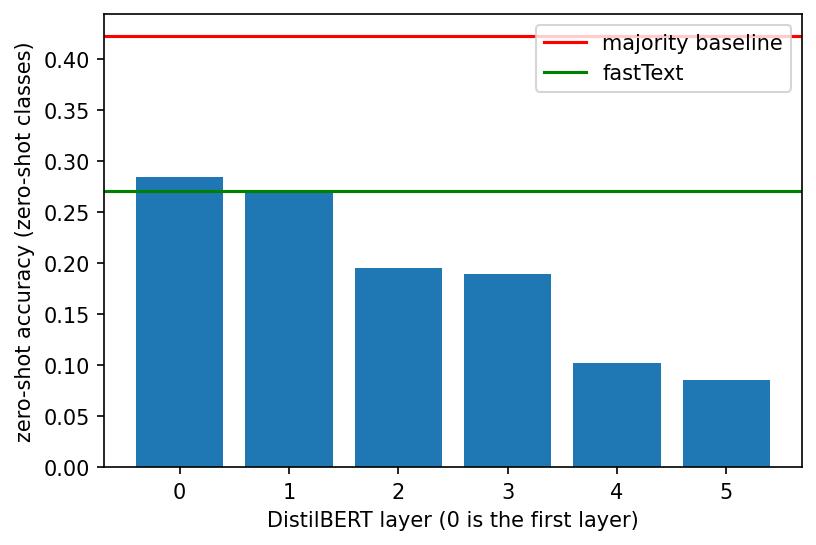

In [21]:
fix, ax = plt.subplots(dpi=150)

# MIND THE REVERSE!!

ax.bar(list(layer2acc.keys()), list(layer2acc.values()))
# ax.set_title("zero-shot accuracy (no training)")
ax.set_xlabel("DistilBERT layer (0 is the first layer)")
ax.set_ylabel("accuracy (zero-shot classes)")

ax.axhline(majority_acc, color="r", label="majority baseline")
ax.axhline(fast_text_acc, color="g", label="fastText")
# ax.axhline(0.44, color="b", label="binary-BERT baseline (Yin et al., 2019)")
# ax.axhline(0.48, color="m", label="SOTA (Yin et al., 2019)")

ax.legend()

In [1]:
layer2acc = {0: 0.28450704225352114,
 1: 0.2707042253521127,
 2: 0.19521126760563381,
 3: 0.18943661971830986,
 4: 0.10225352112676056,
 5: 0.0852112676056338}